# HW1: Get to know the data
HW1 introduces you the Fashion Mnist dataset with some useful preprocessing and visualization methods, and covers K-Means clustering for this dataset.

In [1]:
import os
import sys
sys.path.append("../../homework")
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

## Fashion Mnist 
Read [here](https://github.com/zalandoresearch/fashion-mnist) to learn more about the Fashion Mnist  dataset. 

In [2]:
# Load the Fashion Mnist  data
import mnist_reader
trainX, trainy = mnist_reader.load_mnist('../data/', kind='train')
testX, testy = mnist_reader.load_mnist('../data/', kind='t10k')

In [3]:
# Print some statistics about the data
print("train image data shape:", trainX.shape)
print("train label data shape:", trainy.shape)
print("test image data shape:", testX.shape)
print("test label data shape:", testy.shape)

train image data shape: (60000, 784)
train label data shape: (60000,)
test image data shape: (10000, 784)
test label data shape: (10000,)


## 1. Visualize the flattened data (20 Points)
The 28x28 Fashion Mnist images have been flattened as 784 x 1 image vectors.

Flattening the data will lead to some loss of information (such as spatial correlation between pixels) but it is nevertheless useful for training some linear classifiers.

Write some code below to visualize the training “flattened” data. Please provide a brief analysis about the characteristics of flattened data from visualization.

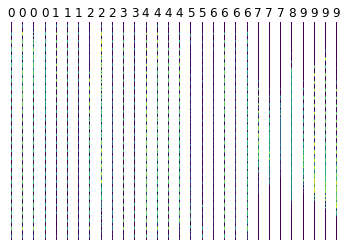

In [4]:
######################################################################
# TODO:                                                              #
# Visualize the data to analyze the characteristics of flattened data#
######################################################################
# your code
######################################################################
import random
choose_num = 30
class_num = 10
classification = {key: [] for key in range(class_num)}
train_num = trainX.shape[0]
for i in range(choose_num):
    idx = random.randint(0, train_num-1)
    classification[trainy[idx]].append(idx)
# random choose some flattened data from training set for visualization
cnt = 1
for i in range(class_num):
    now_class = classification[i]
    for idx in now_class:
        ax2 = plt.subplot(1, choose_num, cnt)
        ax2.imshow(trainX[idx].reshape(784, 1))
        ax2.set_title(i)
        ax2.set_axis_off()
        cnt += 1

#                       END OF YOUR CODE                             #
######################################################################

Discuss: As the result of visualization, it can be oboserved that the flattened data is a line consisting of continuous parts with different colors. The original image and label can be hardly distinguished. The period of flattening change the relationship between adjacent rows and spacial association, which contributes to loss of information. However, flattening still keeps most of information. It tells that images from different label has different color distribution, but for same label images share similar color distribution.

## 2. Visualize the 2D averaged data  (20 Points)
Please write some code to reshape the training flattened data back to 2D 28x28 images and plot every "average" images of classes 0-9. Please provide a brief analysis about the difference between the 2D images and flattened data of Fashion Mnist from visualization.

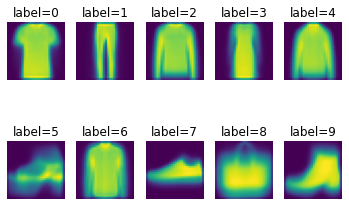

In [5]:
#####################################################################
# TODO:                                                             #
# Plot each "average image" of classes 0-9                          #
#####################################################################
# your code
average_image = np.zeros((10, 784), dtype=np.float_)
image_num = np.zeros(10, dtype=np.int32)
train_num = trainX.shape[0]

for idx, img in enumerate(trainX):
    label = trainy[idx]
    image_num[label] += 1
    average_image[label,...] += img

for i, num in enumerate(image_num):
    average_image[i,...] /= num
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(average_image[i].reshape(28,28))
    ax.set_title('label='+str(i))
    ax.set_axis_off()

#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

Discuss: For the comparison of flattened data and 2D visualization, 2D visualization keeps spatial information between rows and can easily show the original image. Human can tell each label presents which kind of clothes. But for flattened data human eyes can hardly do so.

## 3. Conduct PCA analysis for the flattened data (20 Points)
Please write some code to conduct the Principle Component Analysis (PCA) analysis for the training flattened data, and plot the <font color=black>**first 100 points of**</font> the first principle component against the second principle component. Note: please plot the components in different colors according to their classes. The coordinate of each point is (first_principle_component, second_principle_component).

From the visualization, please give a brief discussion on whether the first principle component and second principle component is sufficient to classify the 10 classes of flattened data?

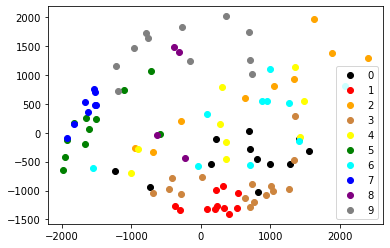

In [6]:
#####################################################################
# TODO:                                                             #
# PCA analysis for the 2D flattened data  
# Hint: from sklearn.decomposition import PCA
#       use PCA(svd_solver='auto').fit_transform(trainX) 
#       to compute the PCA of trainX                                #
#####################################################################
# your code starts here
first_num = 100
from sklearn.decomposition import PCA
trainX_part = trainX[:first_num]
trainy_part = trainy[:first_num]
pca_trainX = PCA(svd_solver='auto', n_components=2).fit_transform(trainX_part) 

# classify 
classified_x = [[] for i in range(10)]
classified_y = [[] for i in range(10)]

for i in range(first_num):
    classified_x[trainy_part[i]].append(pca_trainX[i][0])
    classified_y[trainy_part[i]].append(pca_trainX[i][1])
    
color_map = ['black', 'red', 'orange', 'peru', 'yellow', 'green', 'cyan', 'blue', 'purple', 'gray']
for i in range(10):
    plt.scatter(classified_x[i], classified_y[i], label=str(i), color=color_map[i], marker='o')
plt.legend(loc='best')
plt.show()
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################


Discuss: From PCA visualization, dots from same label is colored with same color. But for one certain color, its dots are not clustered very tight and there is interlace between different labels. This means for some classes there are not linearly separatable. For 2 dimension PCA, first principle PCA and second principle PCA is not sufficient to classify 10 classes of flattened data.

## 4. Implement K-Means clustering to cluster the first and second principle component (PC) of training flattened data (40 Points)

Please write some code to implement the K-Means clustering for the <font color=black>**first 100 points of**</font> first and second principle component (PC) of training flattened data obtained from step 3. Please briefly discuss about the clustering results.

For each of the 100 nodes, its coordinate is (firstPC, secondPC).

In [7]:
k = 10 # set k=10 for 10 classes in Fashion Mnist dataset

### 4.1 Initialization of Centroids (5 Points)

In this step, please randomly pick *k=10* centroids from the 100 1st-2nd PC pairs as centroids initialization.

The method `init_centroids()` should return a list of *k=10* different data points. Example format for 2d data points and *k=10*:

`centroids = [ [0, 0 ], [1, 1 ], [ 2, 2 ], ... ]`

In [8]:
def init_centroids(X, k):
    centroids = None
    
    ### Your code starts here ###############################################################
    centroids = []
    num = X.shape[0]
    num_list = [i for i in range(num)]
    random.shuffle(num_list) # shuffle index 0-99 and take first 10 as initial centroids
    
    for i in range(k):
        idx = num_list[i]
        centroids.append(list(X[idx]))
        
    centroids = np.array(centroids)
    ### Your code ends here #################################################################
    
    return centroids


#
# Example format:
#
# centroids = [ [0, 0 ], [1, 1 ], [ 2, 2 ], ... ]
#
X_kmeans = pca_trainX[:100,:2]  # pca_trainX should be your computed PCA result
centroids = init_centroids(X_kmeans, k)

### 4.2 Cluster Assignment  (10 Points)

In this step, each data point is assigned to its nearest centroid. Hint: you may want to check [`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) and [`numpy.argmin`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) for calculating distances and finding the smallest values.

The method `assign_clusters()` should return a dictionary where the keys represent the ids of the *k* cluster ranging from *0* to *k-1*, and each value is a list of indices of the data points belonging to the respective cluster. For example,

`
clusters = {
   0: [57, 32, 0, 99],
   1: [5, 46, 72],
   2: [92, 15, 26, 97, 30],
   ...
}
`

In [9]:
def assign_clusters(X, k, centroids):
    # Reset all clusters
    clusters = {key: [] for key in range(k)}
    
    for idx, x in enumerate(X):
        
        ### Your code starts here ###############################################################
        
        dist = centroids - x
        label = np.argmin(np.linalg.norm(dist, axis=1))
        clusters[label].append(idx)
        
        ### Your code ends here #################################################################
        
        # Only there so the empty loop does not throw an error
        # (you can remove that once you added your code)

    return clusters

#
# Example format
#
#clusters = {
#   0: [2, 4, 6, 8],
#   1: [0, 1, 5],
#   2: [3, 7, 9]
#}
clusters = assign_clusters(X_kmeans, k, centroids)

### 4.3 Update of Centroids (5 Points)

In this step, please update all centroids based on the assgnment of data points. The updated centroids should be the average of its assigned data points.

The method `update_centroids()` should return a list of the same format as the method `init_centroids()`; see above.

In [10]:
def update_centroids(X, clusters, centroids):
    
    new_centroids = np.zeros_like(centroids)

    ### Your code starts here ###############################################################
    
    class_num = new_centroids.shape[0]
    
    for i in range(class_num):
        class_member = clusters[i]
        for idx in class_member:
            new_centroids[i][0] += X[idx][0]
            new_centroids[i][1] += X[idx][1]
        
        # calculate average 
        new_centroids[i][0] /= len(class_member)
        new_centroids[i][1] /= len(class_member)
    
    ### Your code ends here #################################################################
    return new_centroids


#
centroids = update_centroids(X_kmeans, clusters, centroids)

### 4.4 Implement K-Means clustering using above functions (15 Points)

In this step, please combine the above three steps into a single function to perform the K-Means clustering for the <font color=black>**first 100 of**</font> first and second principle component (PC) of training flattened data obtained from step 3. Note: Don't forget to stop once you find all clusters.

The method `kmeans` should return a clustering (same format as `assign_clusters()` and `update_centroids`), as well as the list of centroids after convergence (same format as `init_centroids()`).

In [11]:
def kmeans(X, k, max_iter=100, verbose=True):
    clusters, num_iterations = {}, 0
    
    centroids = init_centroids(X, k)

    for _ in range(max_iter):
        # Update the counter (+1 since we start from 0)
        num_iterations = num_iterations + 1
        
        ### Your code starts here ###############################################################
        
        clusters = assign_clusters(X, k, centroids)
        centroids = update_centroids(X, clusters, centroids)
    
        ### Your code ends here #################################################################
    
    # Let's print the number of comparison
    if verbose is True:
        print('K-Means required {} iterations to converge.'.format(num_iterations))
    
    return clusters, centroids

### 4.5 Test your Implementation (5 Points)

Run your implementation of K-Means for the <font color=black>**first 100 points of**</font> first and second principle component (PC) of training flattened data obtained from step 3, and visualize the results using the `plot_clusters` method we provide for you.

From the visualization, please briefly discuss about the clustering results.

K-Means required 100 iterations to converge.


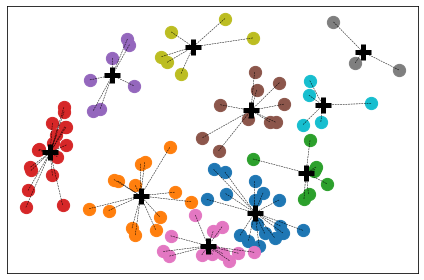

In [12]:
clusters, centroids = kmeans(X_kmeans, k)

mnist_reader.plot_clusters(X_kmeans, clusters, centroids)

Discuss: From the result of clustering, it shows that 100 times of iteration is enough to seperate these 100 points into 10 classes clearly. However compared with PCA visualization, clustering result is not a good classification, the reason is discussed in PCA part that 2-dimension PCA is not sufficient for classification and k-means is a type of unsupervised learning. Since the initial centroids are chosen randomly, and clustering works by calculating distance, the final results will be affected by different initial centroids.

In your submission, in addition to the completed codes and the resulting images for the visualizations, also provide brief responses to the above questions and a brief analysis of the visualized data. 

You may refer to [here](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) for more interesting and beautiful visualisations. Of course, the methods employed are more complex.